In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
epsilon = 0.3
pretrained_model = "model_weights.pth"
use_cuda=True

In [7]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

C:\Users\Alex Vogt\AppData\Local\Programs\Python\Python36\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net()

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  False


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [43]:
# FGSM attack code
def PGD_Attack(image, label, epsilon, data_grad):
    loss = nn.CrossEntropyLoss()
    image.requires_grad = True
    model.zero_grad()

    output = model(image)
    cost = loss(output, label).to(device)
    cost.backward()
    image_grad = image.grad.data

    # perturbed_image = image + (2/255) * image_grad.sign()
    # perturbed_image = torch.clamp(perturbed_image, 0, 1)
    perturbed_image = image + (2/255) * image_grad.sign()
    x = torch.clamp(perturbed_image - image.data, min=-epsilon, max=epsilon)
    perturbed_image = torch.clamp(image + x, min = 0, max = 1).detach_()
    return perturbed_image

In [45]:
def test(model, device, test_loader, epsilon):
    amt_correct = 0
    adv_examples = []

    for data, expected in test_loader:
        data, expected = data.to(device), expected.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != expected.item():
            continue

        loss = F.nll_loss(output, expected)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = PGD_Attack(data, expected, epsilon, data_grad)
        output = model(perturbed_data)

        final_pred = output.max(1, keepdim=True)[1]

        if final_pred.item() == expected.item():
            amt_correct += 1
        else:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            ex = data.squeeze().detach().cpu().numpy()
            adv_examples.append((init_pred.item(), final_pred.item(), adv_ex, ex))

    accuracy = amt_correct/float(len(test_loader))
    print("At Epsilon: {}".format(epsilon))
    print("\nThe neural network got {}/{}".format(amt_correct,float(len(test_loader))))
    print("Or {} percent.".format(accuracy * 100))
    return adv_examples

In [46]:
array = []
epsilon = 0.5
array = test(model, device, test_loader, epsilon)

At Epsilon: 0.5

The neural network got 9348/10000.0
Or 93.47999999999999 percent.


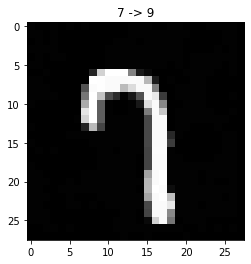

In [47]:
orig, adv, ex, realex = array[2]
plt.title("{} -> {}".format(orig, adv))
plt.imshow(ex, cmap="gray")

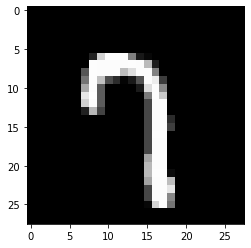

In [48]:
plt.imshow(realex, cmap="gray")